In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
import torch.nn.functional as F
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, classification_report, recall_score, confusion_matrix

1. Loading Dataframe to get dates...
   Found 359 Test Days.
2. Initializing DilatedCNN...
3. Loading Weights from models/best_FINAL_MODEL.pth...
✅ Weights Loaded Successfully.
4. Running Inference (this takes a few minutes)...


100%|██████████| 90/90 [01:28<00:00,  1.02it/s]



FINAL RESULTS: DilatedCNN
🏆 MACRO F1 SCORE: 0.7666

Classification Report:
                  precision    recall  f1-score   support

         Low (1)       0.95      0.99      0.97   1899935
    Moderate (2)       0.81      0.77      0.79   2386216
Considerable (3)       0.73      0.73      0.73   1852085
        High (4)       0.53      0.65      0.58    152268

        accuracy                           0.82   6290504
       macro avg       0.75      0.78      0.77   6290504
    weighted avg       0.82      0.82      0.82   6290504



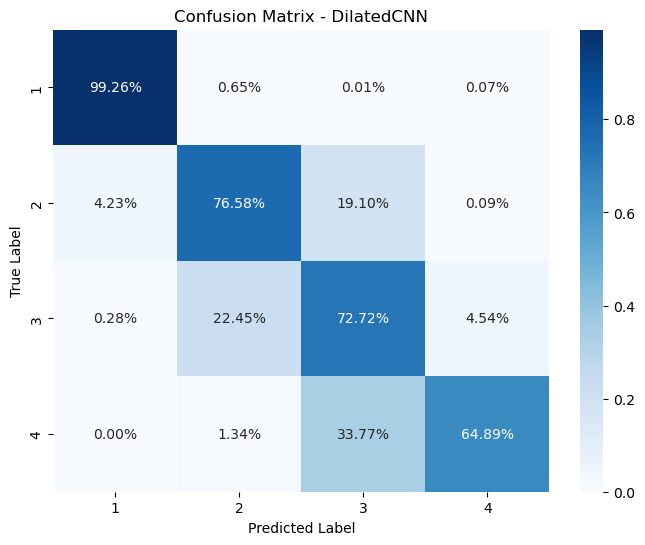

In [5]:
CLEANED_DATA_PATH = '../data/cleaned_data.parquet'
GRID_DIR = '../data/grids'
DYNAMIC_DIR = os.path.join(GRID_DIR, 'dynamic')
TARGET_DIR = os.path.join(GRID_DIR, 'targets')
STATIC_FILE = os.path.join(GRID_DIR, 'static_terrain.npy')
MODEL_DIR = 'models' # Folder where your .pth files are

# Model Selection
ARCH_NAME = "DilatedCNN" # Options: "DilatedCNN", "ConvLSTM", "DeepCNN"
WEIGHTS_PATH = f"{MODEL_DIR}/best_FINAL_MODEL.pth"

# Hyperparameters (Must match training)
BATCH_SIZE = 4
INPUT_CHANNELS = 15 
NUM_CLASSES = 5
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ==============================================================================
# 2. DATASET CLASS DEFINITION
# ==============================================================================
class AvalancheDataset(Dataset):
    def __init__(self, date_list, feature_dir, target_dir, static_file, stats, feature_names, lookback=7):
        self.dates = date_list
        self.feature_dir = feature_dir
        self.target_dir = target_dir
        self.stats = stats
        self.feature_names = feature_names
        self.lookback = lookback
        
        # Load static data 
        self.static_data = np.load(static_file).astype(np.float32)
        if np.max(self.static_data) > 5.0: # Normalization check
            min_val = np.min(self.static_data, axis=(0, 1), keepdims=True)
            max_val = np.max(self.static_data, axis=(0, 1), keepdims=True)
            self.static_data = (self.static_data - min_val) / (max_val - min_val + 1e-6)
        
        self.expected_h = self.static_data.shape[0]
        self.expected_w = self.static_data.shape[1]
        self.expected_c = len(self.feature_names)

    def __len__(self):
        return len(self.dates)

    def __getitem__(self, idx):
        target_date_str = self.dates[idx]
        target_date = pd.to_datetime(target_date_str)
        
        # Build Dynamic Sequence
        frames = []
        start_date = target_date - pd.Timedelta(days=self.lookback - 1)
        
        for i in range(self.lookback):
            d_str = (start_date + pd.Timedelta(days=i)).strftime('%Y-%m-%d')
            f_path = os.path.join(self.feature_dir, f"{d_str}.npz")
            
            if os.path.exists(f_path):
                # Data is already normalized in .npz
                norm_data = np.load(f_path)['data'] 
                frames.append(norm_data)
            else:
                frames.append(np.zeros((self.expected_h, self.expected_w, self.expected_c), dtype=np.float32))
        
        dynamic_tensor = np.stack(frames, axis=0)
        
        # Add Static Data
        static_expanded = np.tile(self.static_data[np.newaxis, ...], (self.lookback, 1, 1, 1))
        full_cube = np.concatenate([dynamic_tensor, static_expanded], axis=-1)
        
        # Load Target
        target_path = os.path.join(self.target_dir, f"{target_date_str}.npy")
        if os.path.exists(target_path):
            label = np.load(target_path).astype(np.int64)
            label[label == -1] = 0 # Handle missing data
        else:
            label = np.zeros((self.expected_h, self.expected_w), dtype=np.int64)

        # Permute to (Channels, Time, Height, Width)
        X = torch.from_numpy(full_cube).permute(3, 0, 1, 2)
        Y = torch.from_numpy(label)
        
        return X, Y

# ==============================================================================
# 3. MODEL ARCHITECTURES (Copy-pasted from Training)
# ==============================================================================
class DeepAvalancheNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(DeepAvalancheNet, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv3d(in_channels, 32, 3, padding=1), nn.BatchNorm3d(32), nn.ReLU(), nn.Dropout3d(0.2))
        self.layer2 = nn.Sequential(nn.Conv3d(32, 64, 3, padding=1), nn.BatchNorm3d(64), nn.ReLU(), nn.MaxPool3d((1, 2, 2)), nn.Dropout3d(0.2))
        self.layer3 = nn.Sequential(nn.Conv3d(64, 128, 3, padding=1), nn.BatchNorm3d(128), nn.ReLU(), nn.Dropout3d(0.3))
        self.layer4 = nn.Sequential(nn.Conv3d(128, 256, 3, padding=1), nn.BatchNorm3d(256), nn.ReLU(), nn.MaxPool3d((1, 2, 2)), nn.Dropout3d(0.3))
        self.pool = nn.AdaptiveAvgPool3d((1, None, None))
        self.final = nn.Conv2d(256, num_classes, 1)

    def forward(self, x):
        orig_size = (x.shape[3], x.shape[4]) 
        x = self.layer4(self.layer3(self.layer2(self.layer1(x))))
        x = self.pool(x).squeeze(2)
        x = F.interpolate(x, size=orig_size, mode='bilinear', align_corners=True)
        return self.final(x)

class DilatedAvalancheNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(DilatedAvalancheNet, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv3d(in_channels, 32, 3, padding=1), nn.BatchNorm3d(32), nn.ReLU())
        self.layer2 = nn.Sequential(nn.Conv3d(32, 64, 3, padding=1), nn.BatchNorm3d(64), nn.ReLU(), nn.MaxPool3d((1, 2, 2)))
        self.layer3 = nn.Sequential(nn.Conv3d(64, 128, 3, padding=2, dilation=2), nn.BatchNorm3d(128), nn.ReLU(), nn.Dropout3d(0.3))
        self.layer4 = nn.Sequential(
            nn.Conv3d(128, 256, 3, padding=2, dilation=2), 
            nn.BatchNorm3d(256), nn.ReLU(), 
            nn.MaxPool3d((1, 2, 2), padding=(0, 1, 1)), 
            nn.Dropout3d(0.3)
        )
        self.pool = nn.AdaptiveAvgPool3d((1, None, None))
        self.final = nn.Conv2d(256, num_classes, 1)

    def forward(self, x):
        orig_size = (x.shape[3], x.shape[4])
        x = self.layer4(self.layer3(self.layer2(self.layer1(x))))
        x = self.pool(x).squeeze(2)
        x = F.interpolate(x, size=orig_size, mode='bilinear', align_corners=True)
        return self.final(x)

class AvalancheConvLSTM(nn.Module):
    def __init__(self, in_channels, num_classes, hidden_dim=64):
        super(AvalancheConvLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, hidden_dim, 3, padding=1), nn.ReLU()
        )
        self.lstm_gate = nn.Conv2d(hidden_dim * 2, hidden_dim * 4, 3, padding=1)
        self.final = nn.Conv2d(hidden_dim, num_classes, 1)

    def forward(self, x):
        b, c, t, h, w = x.size()
        x_flat = x.permute(0, 2, 1, 3, 4).reshape(b * t, c, h, w)
        feats = self.conv(x_flat).view(b, t, self.hidden_dim, h, w)
        ht = torch.zeros(b, self.hidden_dim, h, w).to(x.device)
        ct = torch.zeros(b, self.hidden_dim, h, w).to(x.device)
        for i in range(t):
            combined = torch.cat([feats[:, i], ht], dim=1)
            gates = self.lstm_gate(combined)
            i_gate, f_gate, c_gate, o_gate = gates.chunk(4, 1)
            ct = torch.sigmoid(f_gate) * ct + torch.sigmoid(i_gate) * torch.tanh(c_gate)
            ht = torch.sigmoid(o_gate) * torch.tanh(ct)
        return self.final(ht)

# ==============================================================================
# 4. EXECUTION LOGIC
# ==============================================================================
print("1. Loading Dataframe to get dates...")
df = pd.read_parquet(CLEANED_DATA_PATH)
test_dates = df[df['set'] == 'test']['datum'].unique().astype(str)
print(f"   Found {len(test_dates)} Test Days.")

# Feature Config
dynamic_features = ['delta_elevation', 'Pen_depth', 'HN24', 'MS_Snow', 'TA', 
                    'wind_trans24', 'RH', 'min_ccl_pen', 'relative_load_3d', 'wind_u', 'wind_v']
stats = {} # Dummy stats (normalization handled in dataset or Pre-proc)

# Initialize Model
print(f"2. Initializing {ARCH_NAME}...")
if ARCH_NAME == "DilatedCNN":
    model = DilatedAvalancheNet(in_channels=INPUT_CHANNELS, num_classes=5).to(DEVICE)
elif ARCH_NAME == "ConvLSTM":
    model = AvalancheConvLSTM(in_channels=INPUT_CHANNELS, num_classes=5).to(DEVICE)
else:
    model = DeepAvalancheNet(in_channels=INPUT_CHANNELS, num_classes=5).to(DEVICE)

# Load Weights
print(f"3. Loading Weights from {WEIGHTS_PATH}...")
if not os.path.exists(WEIGHTS_PATH):
    print("❌ ERROR: Weights file not found! Upload your .pth file.")
else:
    model.load_state_dict(torch.load(WEIGHTS_PATH, map_location=DEVICE))
    model.eval()
    print("✅ Weights Loaded Successfully.")

    # Create DataLoader
    test_ds = AvalancheDataset(test_dates, DYNAMIC_DIR, TARGET_DIR, STATIC_FILE, stats, dynamic_features)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    # Run Evaluation
    print("4. Running Inference (this takes a few minutes)...")
    test_preds = []
    test_targets = []

    with torch.no_grad():
        for X, Y in tqdm(test_loader):
            X = X.to(DEVICE)
            Y = Y.to(DEVICE)
            
            outputs = model(X)
            preds = torch.argmax(outputs, dim=1)
            
            # Mask out 'No Data' pixels (Label 0)
            mask = Y != 0
            test_preds.extend(preds[mask].cpu().numpy())
            test_targets.extend(Y[mask].cpu().numpy())

    # Metrics
    print("\n" + "="*40)
    print(f"FINAL RESULTS: {ARCH_NAME}")
    print("="*40)
    
    macro_f1 = f1_score(test_targets, test_preds, average='macro')
    print(f"🏆 MACRO F1 SCORE: {macro_f1:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(test_targets, test_preds, 
                                target_names=['Low (1)', 'Moderate (2)', 'Considerable (3)', 'High (4)']))

    # Confusion Matrix Plot
    cm = confusion_matrix(test_targets, test_preds)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues', 
                xticklabels=[1,2,3,4], yticklabels=[1,2,3,4])
    plt.title(f'Confusion Matrix - {ARCH_NAME}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

Available layers: ['tlm_hoheitsgrenze', 'tlm_hoheitsgebiet', 'tlm_bezirksgebiet', 'tlm_landesgebiet', 'tlm_kantonsgebiet']
✅ Loaded Swiss canton boundaries: 26 features
   CRS: EPSG:2056
Grid shape: 211 rows x 470 cols
   Clipped to 26 boundary features


C:\Users\fabio\AppData\Local\Temp\ipykernel_5448\809864277.py:135: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


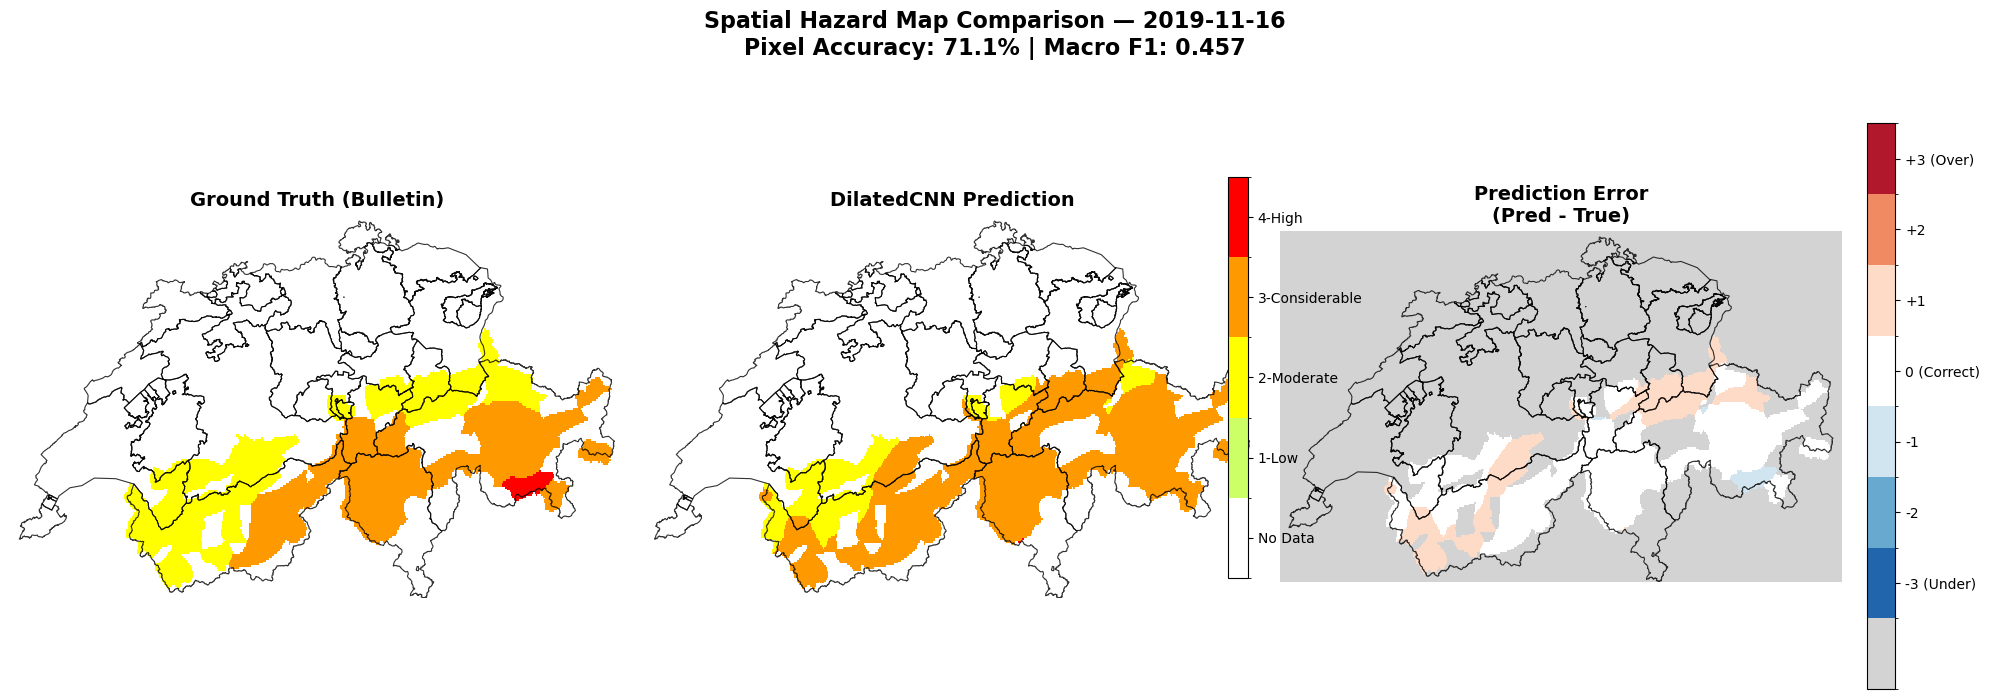


📊 Class Distribution for 2019-11-16:
   Class 1: Ground Truth   0.0% | Predicted   0.0%
   Class 2: Ground Truth  45.7% | Predicted  19.3%
   Class 3: Ground Truth  52.2% | Predicted  80.6%
   Class 4: Ground Truth   2.1% | Predicted   0.0%


In [10]:
# ==============================================================================
# PLOT 1: THE SPATIAL HAZARD MAP (Fixed - Flipped Grid)
# ==============================================================================
import matplotlib.colors as mcolors
import geopandas as gpd
from matplotlib.patches import Patch

# Load Swiss boundaries
BOUNDARIES_PATH = '../data/swissboundaries.gpkg'
try:
    layers = gpd.list_layers(BOUNDARIES_PATH)
    print(f"Available layers: {layers['name'].tolist()}")
    swiss_bounds = gpd.read_file(BOUNDARIES_PATH, layer='tlm_kantonsgebiet')
    has_boundaries = True
    print(f"✅ Loaded Swiss canton boundaries: {len(swiss_bounds)} features")
    print(f"   CRS: {swiss_bounds.crs}")
except Exception as e:
    print(f"⚠️ Could not load boundaries: {e}")
    has_boundaries = False

# 1. Pick a day with High Danger from the Test Set
target_idx = -1
target_date = None
for i, (X, Y) in enumerate(test_loader):
    if (Y == 4).sum() > 50:
        target_idx = i
        sample_X = X
        sample_Y = Y
        batch_start = i * BATCH_SIZE
        target_date = test_dates[batch_start]
        break

if target_idx != -1:
    with torch.no_grad():
        sample_X = sample_X.to(DEVICE)
        output = model(sample_X)
        pred_map = torch.argmax(output, dim=1).cpu().numpy()[0]
        true_map = sample_Y[0].numpy()

    valid_mask = true_map != 0
    pred_map_masked = np.where(valid_mask, pred_map, 0)
    
    diff_map = np.zeros_like(true_map, dtype=np.int8)
    diff_map[valid_mask] = pred_map_masked[valid_mask] - true_map[valid_mask]
    diff_map[~valid_mask] = -99

    valid_true = true_map[valid_mask]
    valid_pred = pred_map_masked[valid_mask]
    pixel_accuracy = (valid_true == valid_pred).mean() * 100
    sample_f1 = f1_score(valid_true, valid_pred, average='macro', zero_division=0)
    
    # Colormaps
    cmap_hazard = mcolors.ListedColormap(['white', '#CCFF66', '#FFFF00', '#FF9900', '#FF0000'])
    bounds_hazard = [0, 1, 2, 3, 4, 5]
    norm_hazard = mcolors.BoundaryNorm(bounds_hazard, cmap_hazard.N)
    
    cmap_diff = mcolors.ListedColormap(['lightgray', '#2166AC', '#67A9CF', '#D1E5F0', 
                                         'white', '#FDDBC7', '#EF8A62', '#B2182B'])
    bounds_diff = [-99.5, -3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5]
    norm_diff = mcolors.BoundaryNorm(bounds_diff, cmap_diff.N)

    h, w = true_map.shape
    print(f"Grid shape: {h} rows x {w} cols")
    
    # Swiss Alps extent in LV95 (meters)
    xmin_lv95 = 2480000
    xmax_lv95 = 2840000
    ymin_lv95 = 1075000
    ymax_lv95 = 1300000
    
    extent_lv95 = [xmin_lv95, xmax_lv95, ymin_lv95, ymax_lv95]
    
    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=(20, 7))
    
    # Prepare boundaries in LV95
    if has_boundaries:
        if swiss_bounds.crs.to_epsg() != 2056:
            bounds_lv95 = swiss_bounds.to_crs(epsg=2056)
        else:
            bounds_lv95 = swiss_bounds
        
        from shapely.geometry import box
        bbox = box(xmin_lv95, ymin_lv95, xmax_lv95, ymax_lv95)
        bounds_clipped = gpd.clip(bounds_lv95, bbox)
        print(f"   Clipped to {len(bounds_clipped)} boundary features")
    
    def add_boundaries(ax):
        if has_boundaries and len(bounds_clipped) > 0:
            bounds_clipped.boundary.plot(ax=ax, color='black', linewidth=0.8, alpha=0.8)
    
    # KEY FIX: Use origin='lower' so row 0 is at bottom (south)
    # This aligns with Swiss LV95 where lower Y = south
    im1 = axes[0].imshow(true_map, cmap=cmap_hazard, norm=norm_hazard, 
                          interpolation='nearest', extent=extent_lv95, 
                          origin='lower', aspect='equal')
    axes[0].set_title("Ground Truth (Bulletin)", fontsize=14, fontweight='bold')
    add_boundaries(axes[0])
    axes[0].set_xlim(xmin_lv95, xmax_lv95)
    axes[0].set_ylim(ymin_lv95, ymax_lv95)
    axes[0].axis('off')
    
    im2 = axes[1].imshow(pred_map_masked, cmap=cmap_hazard, norm=norm_hazard, 
                          interpolation='nearest', extent=extent_lv95, 
                          origin='lower', aspect='equal')
    axes[1].set_title("DilatedCNN Prediction", fontsize=14, fontweight='bold')
    add_boundaries(axes[1])
    axes[1].set_xlim(xmin_lv95, xmax_lv95)
    axes[1].set_ylim(ymin_lv95, ymax_lv95)
    axes[1].axis('off')
    
    im3 = axes[2].imshow(diff_map, cmap=cmap_diff, norm=norm_diff, 
                          interpolation='nearest', extent=extent_lv95, 
                          origin='lower', aspect='equal')
    axes[2].set_title("Prediction Error\n(Pred - True)", fontsize=14, fontweight='bold')
    add_boundaries(axes[2])
    axes[2].set_xlim(xmin_lv95, xmax_lv95)
    axes[2].set_ylim(ymin_lv95, ymax_lv95)
    axes[2].axis('off')
    
    # Colorbars
    cbar1 = fig.colorbar(im1, ax=axes[:2], fraction=0.02, pad=0.04, 
                         ticks=[0.5, 1.5, 2.5, 3.5, 4.5])
    cbar1.ax.set_yticklabels(['No Data', '1-Low', '2-Moderate', '3-Considerable', '4-High'])
    
    cbar2 = fig.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04,
                         ticks=[-3, -2, -1, 0, 1, 2, 3])
    cbar2.ax.set_yticklabels(['-3 (Under)', '-2', '-1', '0 (Correct)', '+1', '+2', '+3 (Over)'])
    
    date_str = target_date if target_date else f"Batch {target_idx}"
    plt.suptitle(f"Spatial Hazard Map Comparison — {date_str}\n"
                 f"Pixel Accuracy: {pixel_accuracy:.1f}% | Macro F1: {sample_f1:.3f}", 
                 fontsize=16, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 Class Distribution for {date_str}:")
    for cls in range(1, 5):
        true_pct = (valid_true == cls).sum() / len(valid_true) * 100
        pred_pct = (valid_pred == cls).sum() / len(valid_pred) * 100
        print(f"   Class {cls}: Ground Truth {true_pct:5.1f}% | Predicted {pred_pct:5.1f}%")
else:
    print("Could not find a high-danger day in the first few batches.")

Available layers: ['tlm_hoheitsgrenze', 'tlm_hoheitsgebiet', 'tlm_bezirksgebiet', 'tlm_landesgebiet', 'tlm_kantonsgebiet']
✅ Loaded Swiss canton boundaries: 26 features
   CRS: EPSG:2056
   Clipped to 26 boundary features
Found 3 days for visualization


C:\Users\fabio\AppData\Local\Temp\ipykernel_5448\552228530.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


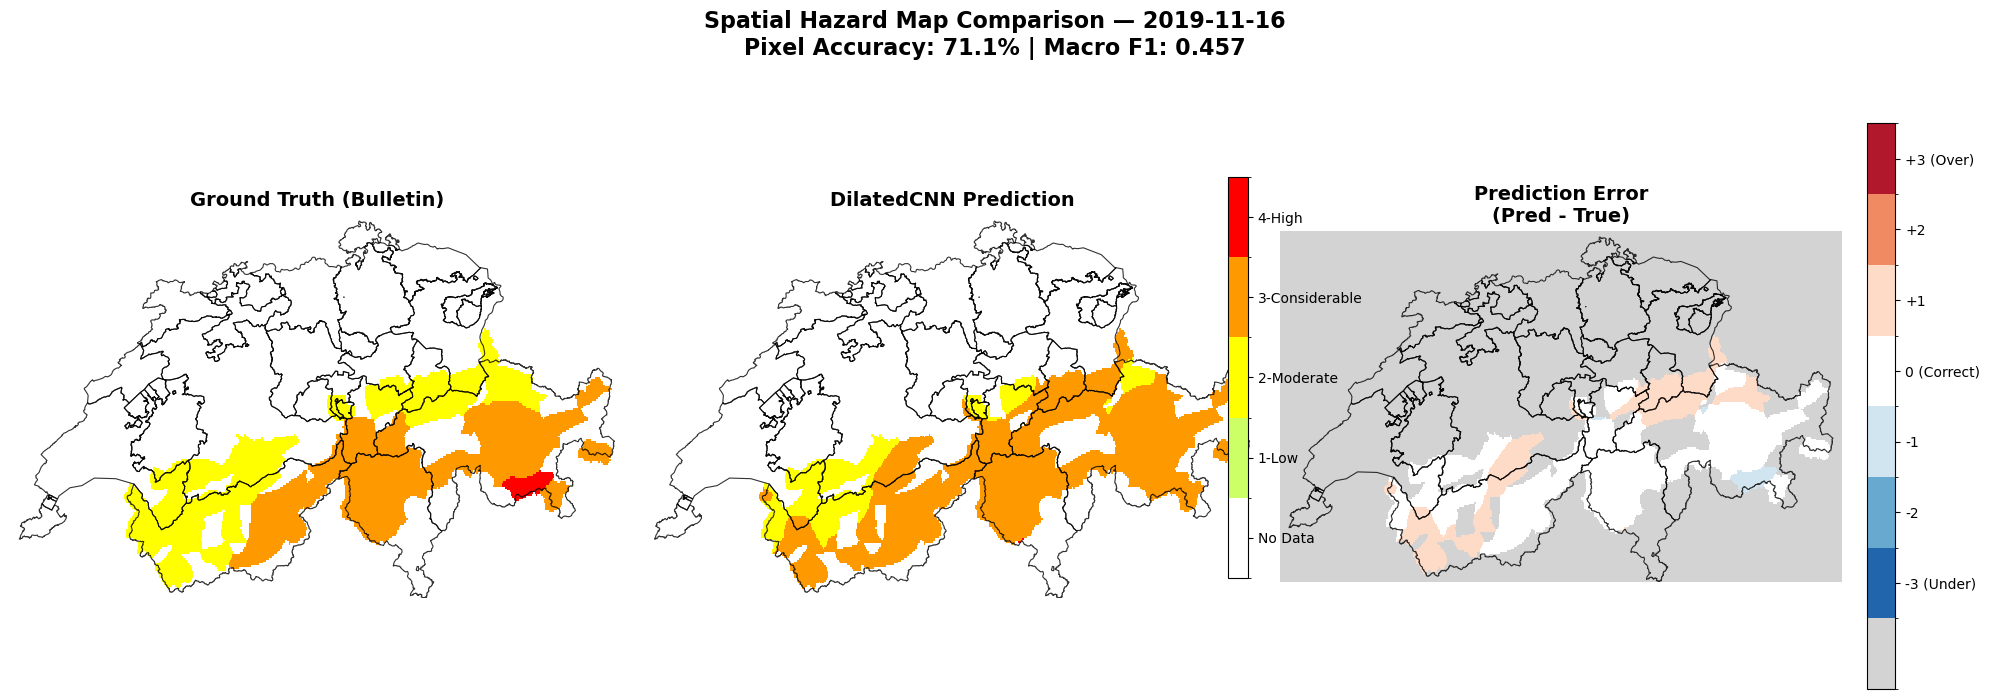


📊 Class Distribution for 2019-11-16:
   Class 1: Ground Truth   0.0% | Predicted   0.0%
   Class 2: Ground Truth  45.7% | Predicted  19.3%
   Class 3: Ground Truth  52.2% | Predicted  80.6%
   Class 4: Ground Truth   2.1% | Predicted   0.0%
--------------------------------------------------


C:\Users\fabio\AppData\Local\Temp\ipykernel_5448\552228530.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


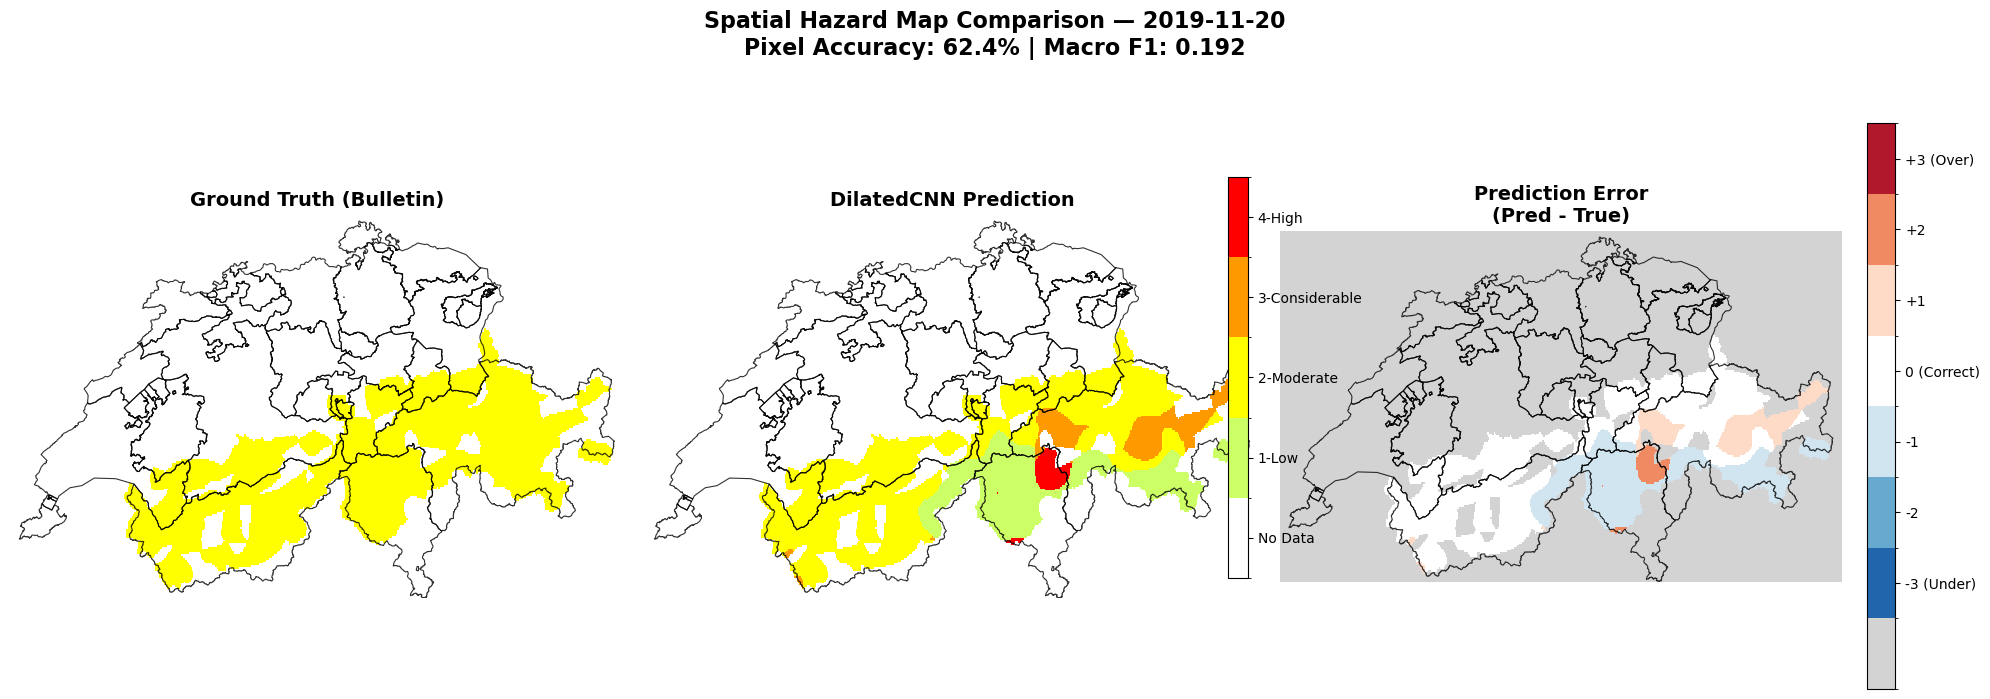


📊 Class Distribution for 2019-11-20:
   Class 1: Ground Truth   0.0% | Predicted  25.0%
   Class 2: Ground Truth 100.0% | Predicted  62.4%
   Class 3: Ground Truth   0.0% | Predicted  10.1%
   Class 4: Ground Truth   0.0% | Predicted   2.5%
--------------------------------------------------


C:\Users\fabio\AppData\Local\Temp\ipykernel_5448\552228530.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


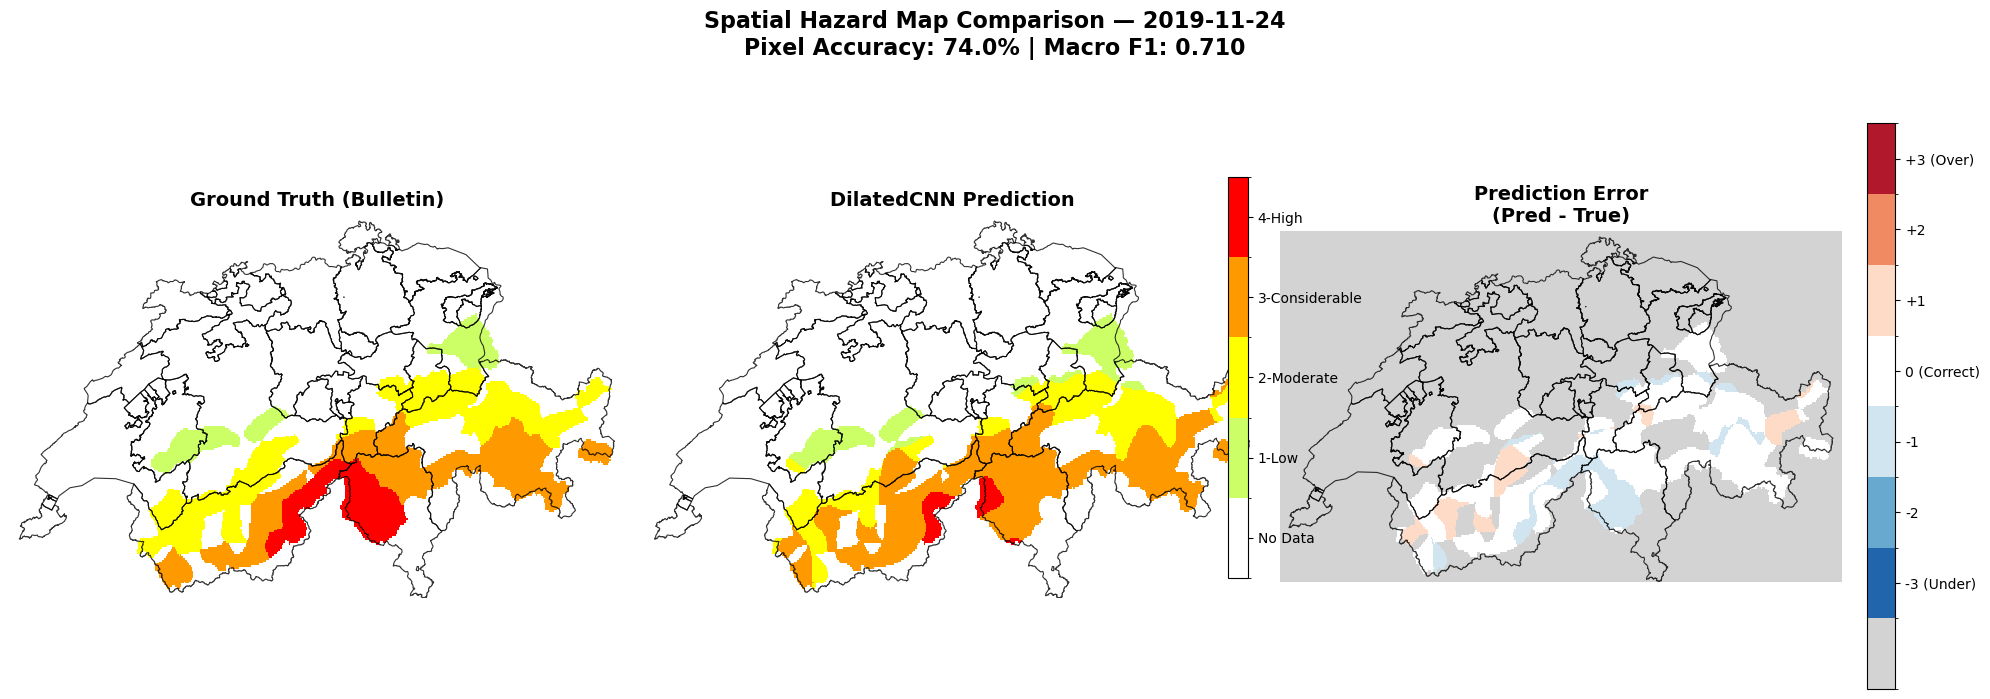


📊 Class Distribution for 2019-11-24:
   Class 1: Ground Truth  12.0% | Predicted  14.0%
   Class 2: Ground Truth  37.8% | Predicted  27.6%
   Class 3: Ground Truth  36.2% | Predicted  54.4%
   Class 4: Ground Truth  14.0% | Predicted   4.0%
--------------------------------------------------


In [11]:
# ==============================================================================
# PLOT 1: SPATIAL HAZARD MAPS FOR MULTIPLE DAYS
# ==============================================================================
import matplotlib.colors as mcolors
import geopandas as gpd
from matplotlib.patches import Patch

# Load Swiss boundaries
BOUNDARIES_PATH = '../data/swissboundaries.gpkg'
try:
    layers = gpd.list_layers(BOUNDARIES_PATH)
    print(f"Available layers: {layers['name'].tolist()}")
    swiss_bounds = gpd.read_file(BOUNDARIES_PATH, layer='tlm_kantonsgebiet')
    has_boundaries = True
    print(f"✅ Loaded Swiss canton boundaries: {len(swiss_bounds)} features")
    print(f"   CRS: {swiss_bounds.crs}")
except Exception as e:
    print(f"⚠️ Could not load boundaries: {e}")
    has_boundaries = False

# Swiss Alps extent in LV95 (meters)
xmin_lv95 = 2480000
xmax_lv95 = 2840000
ymin_lv95 = 1075000
ymax_lv95 = 1300000
extent_lv95 = [xmin_lv95, xmax_lv95, ymin_lv95, ymax_lv95]

# Prepare boundaries in LV95
if has_boundaries:
    if swiss_bounds.crs.to_epsg() != 2056:
        bounds_lv95 = swiss_bounds.to_crs(epsg=2056)
    else:
        bounds_lv95 = swiss_bounds
    
    from shapely.geometry import box
    bbox = box(xmin_lv95, ymin_lv95, xmax_lv95, ymax_lv95)
    bounds_clipped = gpd.clip(bounds_lv95, bbox)
    print(f"   Clipped to {len(bounds_clipped)} boundary features")

def add_boundaries(ax):
    if has_boundaries and len(bounds_clipped) > 0:
        bounds_clipped.boundary.plot(ax=ax, color='black', linewidth=0.8, alpha=0.8)

# Colormaps
cmap_hazard = mcolors.ListedColormap(['white', '#CCFF66', '#FFFF00', '#FF9900', '#FF0000'])
bounds_hazard = [0, 1, 2, 3, 4, 5]
norm_hazard = mcolors.BoundaryNorm(bounds_hazard, cmap_hazard.N)

cmap_diff = mcolors.ListedColormap(['lightgray', '#2166AC', '#67A9CF', '#D1E5F0', 
                                     'white', '#FDDBC7', '#EF8A62', '#B2182B'])
bounds_diff = [-99.5, -3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5]
norm_diff = mcolors.BoundaryNorm(bounds_diff, cmap_diff.N)

# ==============================================================================
# Find 3 different days with varying danger levels
# ==============================================================================
selected_days = []
criteria = [
    lambda Y: (Y == 4).sum() > 50,   # Day with High danger
    lambda Y: (Y == 3).sum() > 200,  # Day with lots of Considerable
    lambda Y: (Y == 2).sum() > 300,  # Day with mostly Moderate
]

for i, (X, Y) in enumerate(test_loader):
    for j, criterion in enumerate(criteria):
        if j < len(selected_days):
            continue
        if criterion(Y):
            batch_start = i * BATCH_SIZE
            selected_days.append({
                'batch_idx': i,
                'X': X,
                'Y': Y,
                'date': test_dates[batch_start]
            })
            break
    if len(selected_days) >= 3:
        break

print(f"Found {len(selected_days)} days for visualization")

# ==============================================================================
# Create visualization for each selected day
# ==============================================================================
for day_info in selected_days:
    with torch.no_grad():
        sample_X = day_info['X'].to(DEVICE)
        output = model(sample_X)
        pred_map = torch.argmax(output, dim=1).cpu().numpy()[0]
        true_map = day_info['Y'][0].numpy()

    valid_mask = true_map != 0
    pred_map_masked = np.where(valid_mask, pred_map, 0)
    
    diff_map = np.zeros_like(true_map, dtype=np.int8)
    diff_map[valid_mask] = pred_map_masked[valid_mask] - true_map[valid_mask]
    diff_map[~valid_mask] = -99

    valid_true = true_map[valid_mask]
    valid_pred = pred_map_masked[valid_mask]
    pixel_accuracy = (valid_true == valid_pred).mean() * 100
    sample_f1 = f1_score(valid_true, valid_pred, average='macro', zero_division=0)
    
    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=(20, 7))
    
    # Ground Truth
    im1 = axes[0].imshow(true_map, cmap=cmap_hazard, norm=norm_hazard, 
                          interpolation='nearest', extent=extent_lv95, 
                          origin='lower', aspect='equal')
    axes[0].set_title("Ground Truth (Bulletin)", fontsize=14, fontweight='bold')
    add_boundaries(axes[0])
    axes[0].set_xlim(xmin_lv95, xmax_lv95)
    axes[0].set_ylim(ymin_lv95, ymax_lv95)
    axes[0].axis('off')
    
    # Prediction
    im2 = axes[1].imshow(pred_map_masked, cmap=cmap_hazard, norm=norm_hazard, 
                          interpolation='nearest', extent=extent_lv95, 
                          origin='lower', aspect='equal')
    axes[1].set_title("DilatedCNN Prediction", fontsize=14, fontweight='bold')
    add_boundaries(axes[1])
    axes[1].set_xlim(xmin_lv95, xmax_lv95)
    axes[1].set_ylim(ymin_lv95, ymax_lv95)
    axes[1].axis('off')
    
    # Difference Map
    im3 = axes[2].imshow(diff_map, cmap=cmap_diff, norm=norm_diff, 
                          interpolation='nearest', extent=extent_lv95, 
                          origin='lower', aspect='equal')
    axes[2].set_title("Prediction Error\n(Pred - True)", fontsize=14, fontweight='bold')
    add_boundaries(axes[2])
    axes[2].set_xlim(xmin_lv95, xmax_lv95)
    axes[2].set_ylim(ymin_lv95, ymax_lv95)
    axes[2].axis('off')
    
    # Colorbars
    cbar1 = fig.colorbar(im1, ax=axes[:2], fraction=0.02, pad=0.04, 
                         ticks=[0.5, 1.5, 2.5, 3.5, 4.5])
    cbar1.ax.set_yticklabels(['No Data', '1-Low', '2-Moderate', '3-Considerable', '4-High'])
    
    cbar2 = fig.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04,
                         ticks=[-3, -2, -1, 0, 1, 2, 3])
    cbar2.ax.set_yticklabels(['-3 (Under)', '-2', '-1', '0 (Correct)', '+1', '+2', '+3 (Over)'])
    
    date_str = day_info['date']
    plt.suptitle(f"Spatial Hazard Map Comparison — {date_str}\n"
                 f"Pixel Accuracy: {pixel_accuracy:.1f}% | Macro F1: {sample_f1:.3f}", 
                 fontsize=16, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    plt.show()
    
    # Class distribution
    print(f"\n📊 Class Distribution for {date_str}:")
    for cls in range(1, 5):
        true_pct = (valid_true == cls).sum() / len(valid_true) * 100
        pred_pct = (valid_pred == cls).sum() / len(valid_pred) * 100
        print(f"   Class {cls}: Ground Truth {true_pct:5.1f}% | Predicted {pred_pct:5.1f}%")
    print("-" * 50)

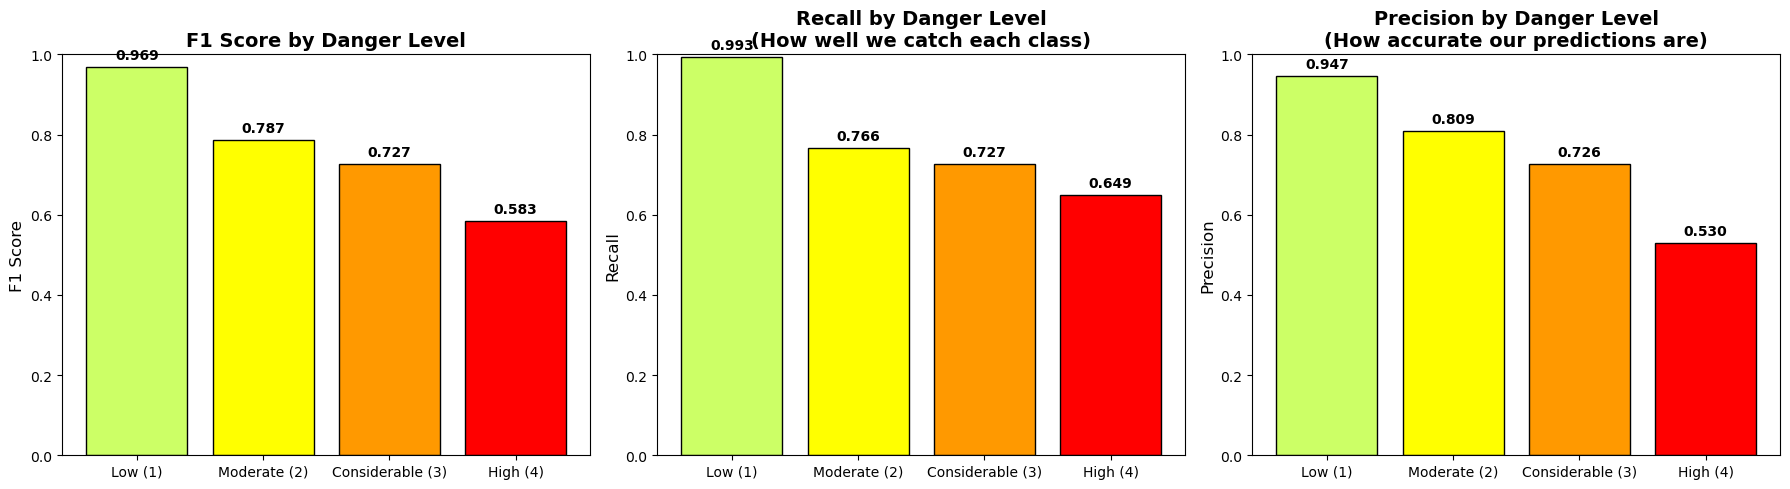

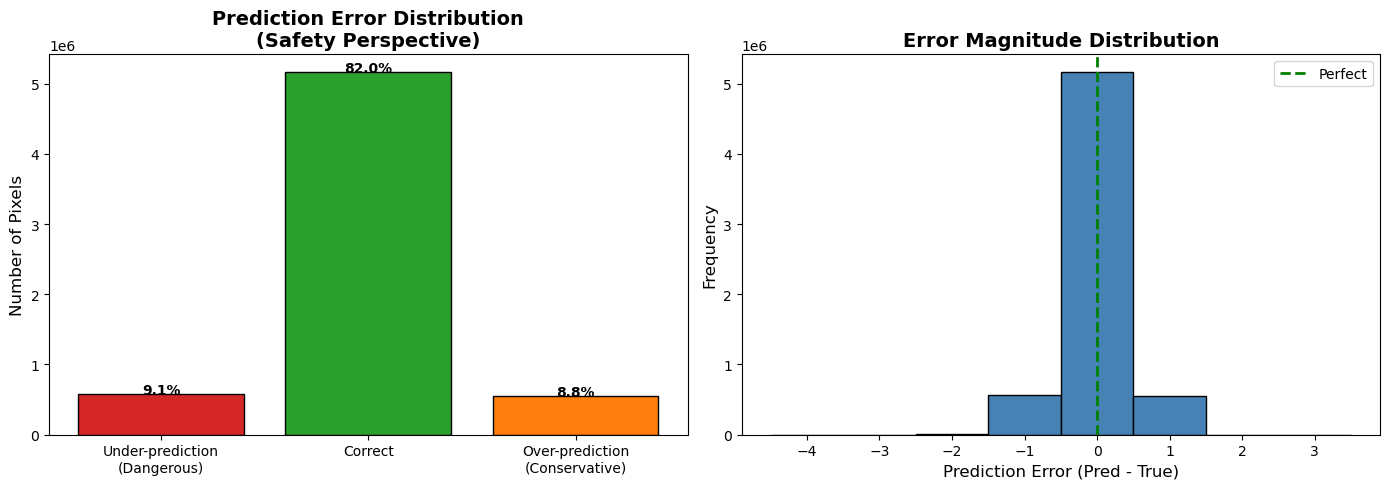

Computing daily metrics: 100%|██████████| 100/100 [00:22<00:00,  4.41it/s]


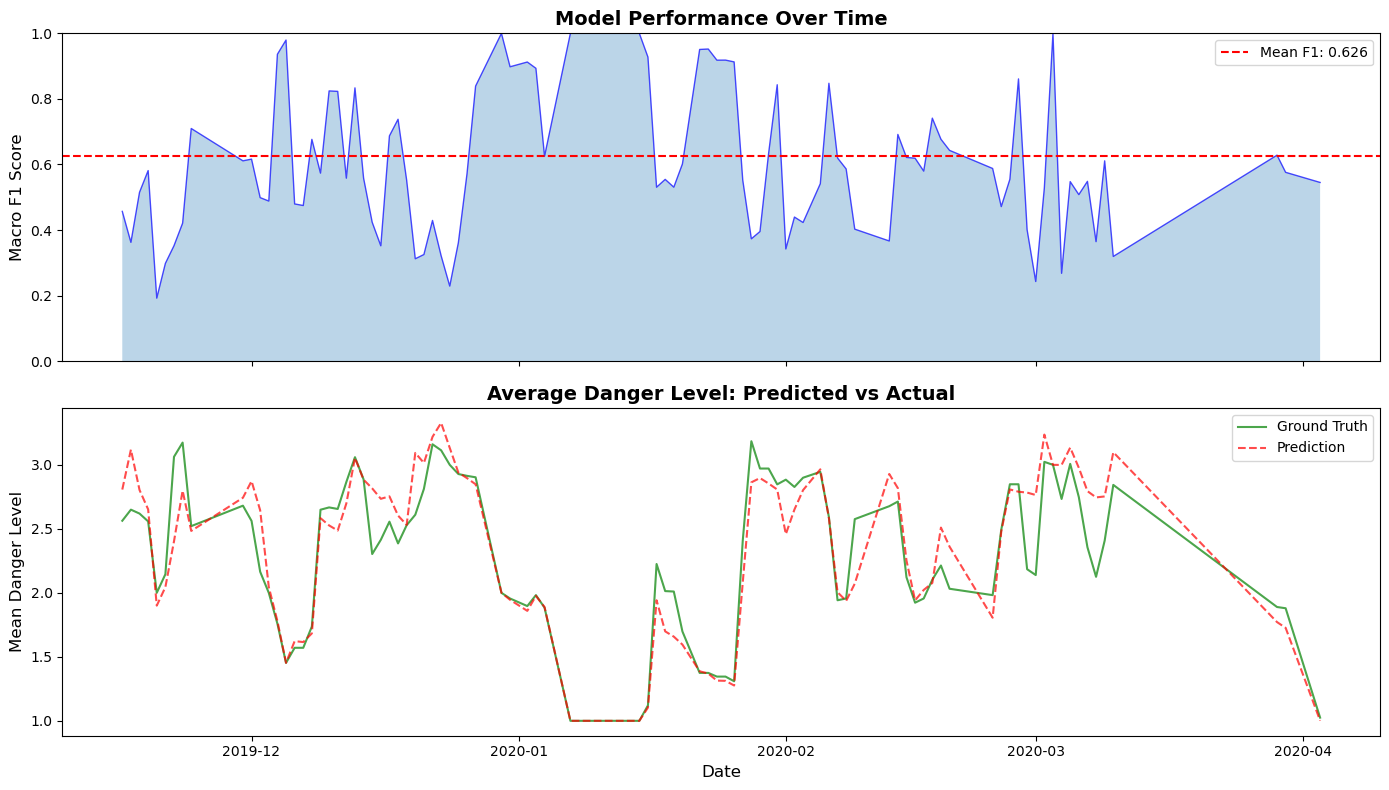

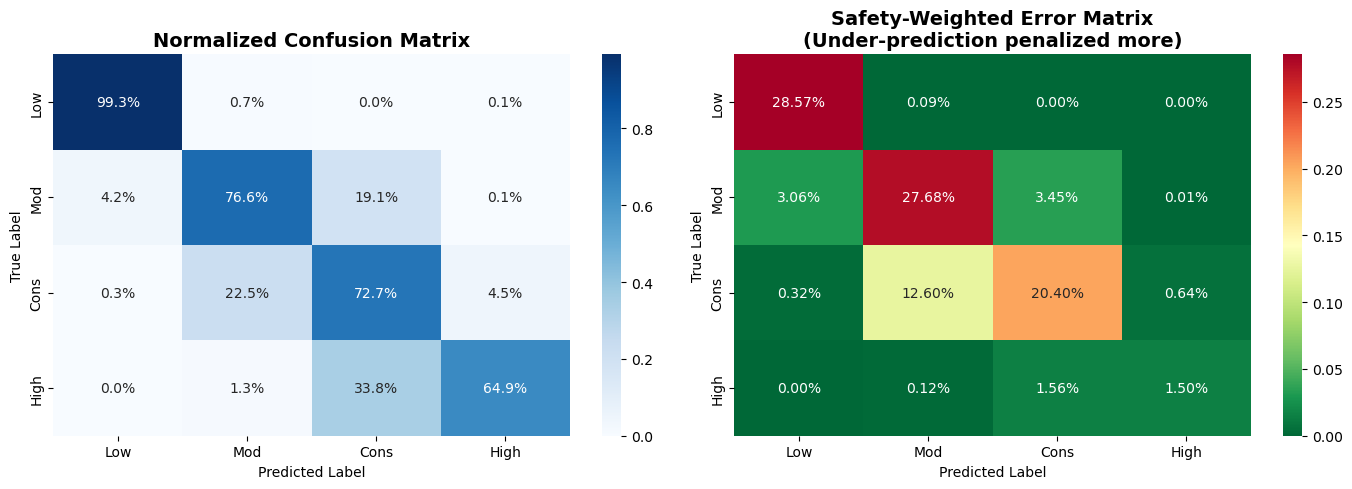

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 17909 and the array at index 1 has size 18698

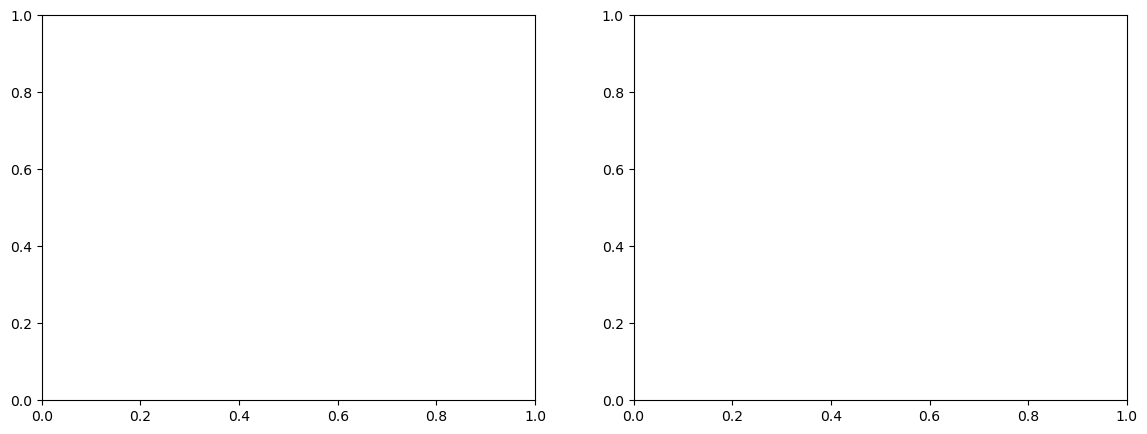

In [ ]:
# ==============================================================================
# PLOT 2: PER-CLASS PERFORMANCE ANALYSIS
# ==============================================================================
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 2a. Per-Class F1 Scores
class_f1 = f1_score(test_targets, test_preds, average=None)
class_names = ['Low (1)', 'Moderate (2)', 'Considerable (3)', 'High (4)']
colors = ['#CCFF66', '#FFFF00', '#FF9900', '#FF0000']

axes[0].bar(class_names, class_f1, color=colors, edgecolor='black')
axes[0].set_ylabel('F1 Score', fontsize=12)
axes[0].set_title('F1 Score by Danger Level', fontsize=14, fontweight='bold')
axes[0].set_ylim(0, 1)
for i, v in enumerate(class_f1):
    axes[0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# 2b. Per-Class Recall (Critical for safety - catching high danger)
class_recall = recall_score(test_targets, test_preds, average=None)
axes[1].bar(class_names, class_recall, color=colors, edgecolor='black')
axes[1].set_ylabel('Recall', fontsize=12)
axes[1].set_title('Recall by Danger Level\n(How well we catch each class)', fontsize=14, fontweight='bold')
axes[1].set_ylim(0, 1)
for i, v in enumerate(class_recall):
    axes[1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# 2c. Class Distribution (Imbalance visualization)
from sklearn.metrics import precision_score
class_precision = precision_score(test_targets, test_preds, average=None)
axes[2].bar(class_names, class_precision, color=colors, edgecolor='black')
axes[2].set_ylabel('Precision', fontsize=12)
axes[2].set_title('Precision by Danger Level\n(How accurate our predictions are)', fontsize=14, fontweight='bold')
axes[2].set_ylim(0, 1)
for i, v in enumerate(class_precision):
    axes[2].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# ==============================================================================
# PLOT 3: ERROR ANALYSIS - SAFETY-CRITICAL METRICS
# ==============================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

test_targets_arr = np.array(test_targets)
test_preds_arr = np.array(test_preds)

# 3a. Under-prediction vs Over-prediction
errors = test_preds_arr - test_targets_arr
under_pred = (errors < 0).sum()
correct = (errors == 0).sum()
over_pred = (errors > 0).sum()

categories = ['Under-prediction\n(Dangerous)', 'Correct', 'Over-prediction\n(Conservative)']
counts = [under_pred, correct, over_pred]
colors_err = ['#d62728', '#2ca02c', '#ff7f0e']

bars = axes[0].bar(categories, counts, color=colors_err, edgecolor='black')
axes[0].set_ylabel('Number of Pixels', fontsize=12)
axes[0].set_title('Prediction Error Distribution\n(Safety Perspective)', fontsize=14, fontweight='bold')
for bar, count in zip(bars, counts):
    pct = count / len(errors) * 100
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000, 
                 f'{pct:.1f}%', ha='center', fontweight='bold')

# 3b. Error magnitude distribution
error_bins = [-4, -3, -2, -1, 0, 1, 2, 3, 4]
hist_colors = ['#08519c', '#2171b5', '#6baed6', '#bdd7e7', 
               '#fee5d9', '#fcae91', '#fb6a4a', '#cb181d']
axes[1].hist(errors, bins=error_bins, color='steelblue', edgecolor='black', align='left')
axes[1].set_xlabel('Prediction Error (Pred - True)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Error Magnitude Distribution', fontsize=14, fontweight='bold')
axes[1].axvline(x=0, color='green', linestyle='--', linewidth=2, label='Perfect')
axes[1].legend()

plt.tight_layout()
plt.show()

# ==============================================================================
# PLOT 4: TEMPORAL PERFORMANCE - F1 OVER TIME
# ==============================================================================
# Calculate daily metrics
daily_metrics = []
test_ds_viz = AvalancheDataset(test_dates, DYNAMIC_DIR, TARGET_DIR, STATIC_FILE, stats, dynamic_features)

for idx in tqdm(range(min(len(test_dates), 100)), desc="Computing daily metrics"):  # Limit for speed
    X, Y = test_ds_viz[idx]
    X = X.unsqueeze(0).to(DEVICE)
    
    with torch.no_grad():
        output = model(X)
        pred = torch.argmax(output, dim=1).cpu().numpy()[0]
    
    true = Y.numpy()
    mask = true != 0
    
    if mask.sum() > 0:
        y_true = true[mask]
        y_pred = pred[mask]
        
        daily_metrics.append({
            'date': pd.to_datetime(test_dates[idx]),
            'f1_macro': f1_score(y_true, y_pred, average='macro', zero_division=0),
            'accuracy': (y_true == y_pred).mean(),
            'mean_true': y_true.mean(),
            'mean_pred': y_pred.mean()
        })

daily_df = pd.DataFrame(daily_metrics)

fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# 4a. F1 Score over time
axes[0].plot(daily_df['date'], daily_df['f1_macro'], 'b-', alpha=0.7, linewidth=1)
axes[0].axhline(y=daily_df['f1_macro'].mean(), color='red', linestyle='--', 
                label=f'Mean F1: {daily_df["f1_macro"].mean():.3f}')
axes[0].fill_between(daily_df['date'], daily_df['f1_macro'], alpha=0.3)
axes[0].set_ylabel('Macro F1 Score', fontsize=12)
axes[0].set_title('Model Performance Over Time', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].set_ylim(0, 1)

# 4b. Average danger level over time
axes[1].plot(daily_df['date'], daily_df['mean_true'], 'g-', label='Ground Truth', alpha=0.7)
axes[1].plot(daily_df['date'], daily_df['mean_pred'], 'r--', label='Prediction', alpha=0.7)
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Mean Danger Level', fontsize=12)
axes[1].set_title('Average Danger Level: Predicted vs Actual', fontsize=14, fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.show()

# ==============================================================================
# PLOT 5: CONFUSION MATRIX WITH COST-SENSITIVE VIEW
# ==============================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 5a. Standard normalized confusion matrix
cm = confusion_matrix(test_targets, test_preds)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_norm, annot=True, fmt='.1%', cmap='Blues', ax=axes[0],
            xticklabels=['Low', 'Mod', 'Cons', 'High'],
            yticklabels=['Low', 'Mod', 'Cons', 'High'])
axes[0].set_title('Normalized Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# 5b. Safety-weighted confusion matrix (penalize under-prediction more)
# Higher cost for under-predicting high danger
safety_weights = np.array([
    [1, 0.5, 0.25, 0.1],   # True=Low
    [2, 1, 0.5, 0.25],     # True=Moderate  
    [4, 2, 1, 0.5],        # True=Considerable
    [8, 4, 2, 1]           # True=High (worst to under-predict)
])

cm_safety = cm * safety_weights
cm_safety_norm = cm_safety / cm_safety.sum()

sns.heatmap(cm_safety_norm, annot=True, fmt='.2%', cmap='RdYlGn_r', ax=axes[1],
            xticklabels=['Low', 'Mod', 'Cons', 'High'],
            yticklabels=['Low', 'Mod', 'Cons', 'High'])
axes[1].set_title('Safety-Weighted Error Matrix\n(Under-prediction penalized more)', 
                  fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# ==============================================================================
# PLOT 6: RELIABILITY DIAGRAM (CALIBRATION)
# ==============================================================================
from sklearn.calibration import calibration_curve

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Get predicted probabilities for calibration analysis
all_probs = []
all_labels = []

for i, (X, Y) in enumerate(test_loader):
    if i >= 50:  # Limit for speed
        break
    X = X.to(DEVICE)
    with torch.no_grad():
        output = model(X)
        probs = F.softmax(output, dim=1).cpu().numpy()
    
    mask = Y.numpy() != 0
    for b in range(X.shape[0]):
        m = mask[b]
        all_probs.append(probs[b, :, m].T)  # (N, 4)
        all_labels.append(Y[b].numpy()[m])

all_probs = np.vstack(all_probs)
all_labels = np.concatenate(all_labels)

# 6a. Calibration curves per class
for cls_idx, cls_name in enumerate(['Low', 'Moderate', 'Considerable', 'High']):
    binary_labels = (all_labels == (cls_idx + 1)).astype(int)
    prob_cls = all_probs[:, cls_idx]
    
    if binary_labels.sum() > 100:
        prob_true, prob_pred = calibration_curve(binary_labels, prob_cls, n_bins=10)
        axes[0].plot(prob_pred, prob_true, marker='o', label=cls_name)

axes[0].plot([0, 1], [0, 1], 'k--', label='Perfect calibration')
axes[0].set_xlabel('Mean Predicted Probability')
axes[0].set_ylabel('Fraction of Positives')
axes[0].set_title('Calibration Curves by Class', fontsize=14, fontweight='bold')
axes[0].legend()

# 6b. Prediction confidence distribution
max_probs = all_probs.max(axis=1)
correct = (all_probs.argmax(axis=1) + 1) == all_labels

axes[1].hist(max_probs[correct], bins=20, alpha=0.7, label='Correct', color='green')
axes[1].hist(max_probs[~correct], bins=20, alpha=0.7, label='Incorrect', color='red')
axes[1].set_xlabel('Prediction Confidence (Max Probability)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Confidence Distribution: Correct vs Incorrect', fontsize=14, fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.show()